In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd 
import pmdarima as pm 
import matplotlib.pyplot as plt 
from pmdarima import pipeline

plt.style.use('bmh')

In [3]:
data = pd.read_csv('../ts_data/Electric_Production.csv', parse_dates=['DATE'], index_col=['DATE'])
data 

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


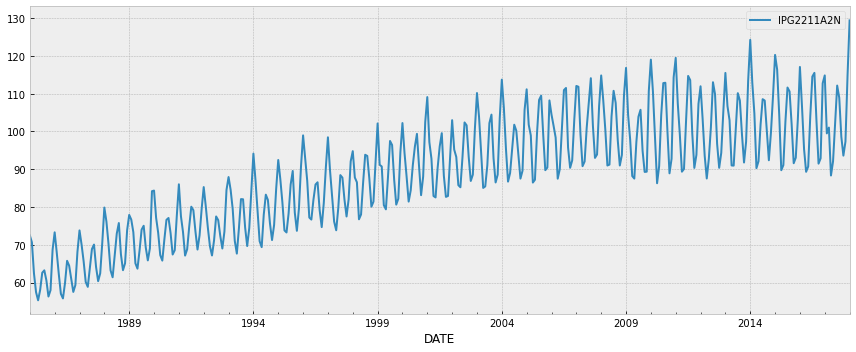

In [4]:
data.plot(figsize=(12,5))
plt.tight_layout()
plt.show()

In [5]:
train, test = pm.model_selection.train_test_split(data, test_size=0.2)
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (317, 1)
Test: (80, 1)


In [6]:
pipe = pipeline.Pipeline([
    ('fourier', pm.preprocessing.FourierFeaturizer(m=12, k=4)),
    ('arima', pm.arima.AutoARIMA(m=12, seasonal=True, trace=True))
])

In [7]:
pipe

Pipeline(steps=[('fourier', FourierFeaturizer(k=4, m=12)),
                ('arima', AutoARIMA(m=12, trace=True))])

In [8]:
pipe.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1419.557, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1578.929, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1510.862, Time=0.59 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1512.488, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1577.514, Time=0.21 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1459.592, Time=1.92 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1445.450, Time=1.94 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1421.340, Time=4.14 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1423.109, Time=4.11 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1491.555, Time=0.99 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1456.139, Time=3.68 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=1438.617, Time=3.94 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=1421.700, Time=4.38 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1417.691, Time=2.04 sec
 ARIMA(1,1,2)(0,0,1

Pipeline(steps=[('fourier', FourierFeaturizer(k=4, m=12)),
                ('arima', AutoARIMA(m=12, trace=True))])

In [9]:
print(pipe.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  317
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -693.845
Date:                              Mon, 21 Mar 2022   AIC                           1417.691
Time:                                      16:08:52   BIC                           1474.027
Sample:                                           0   HQIC                          1440.197
                                              - 317                                         
Covariance Type:                                opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0067      0.005      1.334      0.182      -0.003       0.017
FOURIER_S1

In [10]:
train_pred, train_conf = pipe.predict_in_sample(return_conf_int=True, alpha=0.05)
test_pred, test_conf = pipe.predict(n_periods=len(test), return_conf_int=True, alpha=0.05)

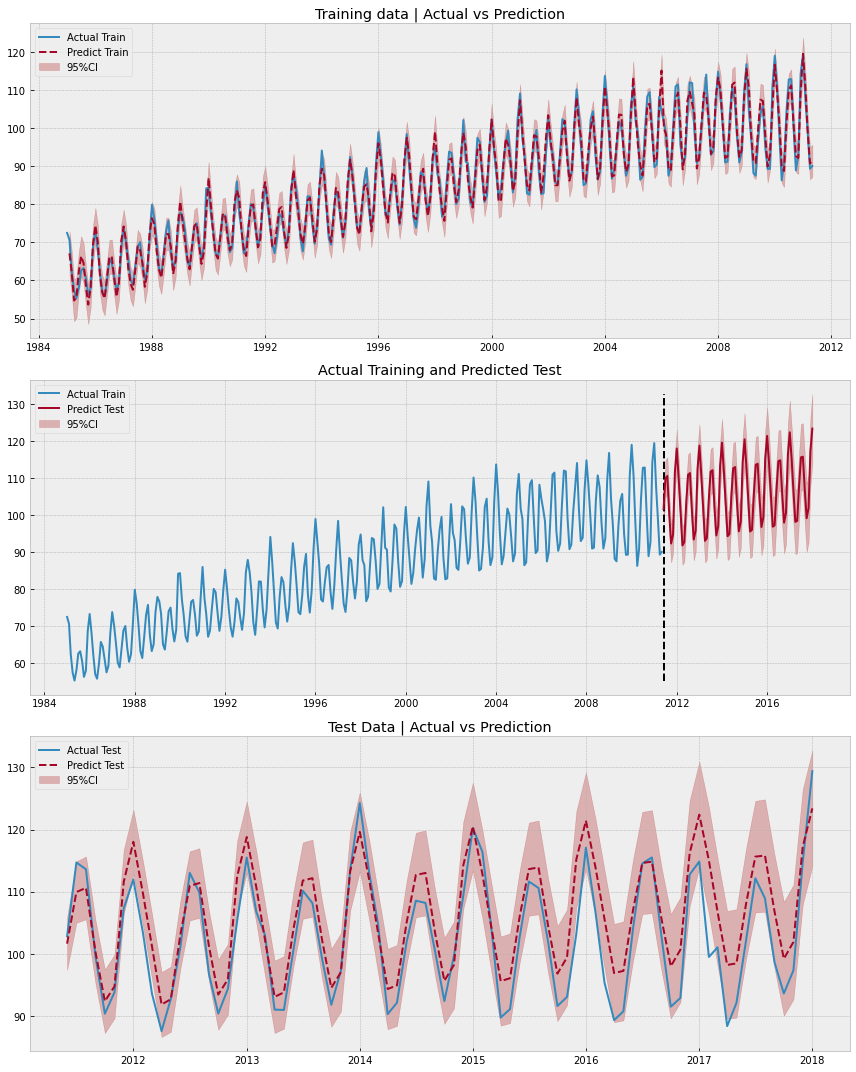

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(12,15))

ax[0].plot(train.index, train.values.flatten(), label='Actual Train')
ax[0].plot(train.index[1:], train_pred[1:], label='Predict Train', linestyle='--')
ax[0].fill_between(x=train.index[1:], y1=train_conf[1:,0], y2=train_conf[1:,1], 
                   alpha=0.3, color='firebrick', label='95%CI')
ax[0].legend()
ax[0].set_title('Training data | Actual vs Prediction')

ax[1].plot(train.index, train.values.flatten(), label='Actual Train')
ax[1].plot(test.index, test_pred, label='Predict Test')
ax[1].fill_between(x=test.index, y1=test_conf[:,0], y2=test_conf[:,1], 
                   color='firebrick', alpha=0.3, label='95%CI')
ax[1].vlines(x=test.index[0], ymax=test_conf.max(), ymin=train.min(), color='k', linestyle='--')
ax[1].legend()
ax[1].set_title('Actual Training and Predicted Test')

ax[2].plot(test.index, test.values.flatten(), label='Actual Test')
ax[2].plot(test.index, test_pred, label='Predict Test', linestyle='--')
ax[2].fill_between(x=test.index, y1=test_conf[:,0], y2=test_conf[:,1], 
                   color='firebrick', alpha=0.3, label='95%CI')
ax[2].legend()
ax[2].set_title('Test Data | Actual vs Prediction')

plt.tight_layout()
plt.show()